##   <font color='Lime'>Import libraries</font> 

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2,EfficientNetB3,EfficientNetB5,InceptionResNetV2#,EfficientNetV2S
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras
from   tensorflow.keras.preprocessing.image import img_to_array, load_img
import random

In [2]:
#!pip install tf-nightly
#!pip install keras_efficientnets

## <font color='Lime'>Create labels</font> 

In [4]:
#create labels
classes=[]
filename=r"C:\\Users\diego\OneDrive\Desktop\DS\brain_cancer\Brain_cancer_classification\data"
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)


['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


## <font color='Lime'>Resize images and put together Training and Testing folder</font> 

In [5]:
#resize images and put together Training and Testing folder

X_train = []
y_train = []
image_size = 160
for i in classes:
    path_train = os.path.join(filename,'Training',i)
    for j in tqdm(os.listdir(path_train)): #Instantly make your loops show a smart progress meter 
        img = cv2.imread(os.path.join(path_train,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
    path_test = os.path.join(filename,'Testing',i)
    for j in tqdm(os.listdir(path_test)):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)    

100%|██████████| 74/74 [00:00<00:00, 244.34it/s]


## <font color='Lime'>Data augmentation</font> 

In [6]:
#data augmentation
X_train, y_train = shuffle(X_train,y_train, random_state=42)
datagen = ImageDataGenerator(
    rotation_range=7,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape
lb = LabelEncoder()

#train and test splitting 
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.15,random_state=42,stratify=y_train)

labels_train=lb.fit(y_train)
y_train=lb.transform(y_train)
y_test=lb.transform(y_test)

## <font color='Lime'>Train the model</font> 

In [18]:
#train the model
tf.random.set_seed(77)
tf.random.set_seed(79)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='elu',kernel_initializer='GlorotNormal', input_shape=(image_size,image_size, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3)),#activation='linear'),
    tf.keras.layers.Activation('linear'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='elu',kernel_initializer='GlorotNormal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='elu',kernel_initializer='GlorotNormal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='elu',kernel_initializer='GlorotNormal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.15),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, activation='elu',kernel_initializer='GlorotNormal'),
    tf.keras.layers.Dropout(rate=0.15),
    tf.keras.layers.Dense(38, activation='elu',kernel_initializer='GlorotNormal'),
    tf.keras.layers.Dropout(rate=0.15),
    tf.keras.layers.Dense(4, activation='sigmoid')
      ])
opt = Adam(
    learning_rate=0.00007,
    epsilon=1e-08)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

# summarize the model
print(model.summary())
# fit the model
early_stopping_cb=keras.callbacks.EarlyStopping(patience=15,restore_best_weights=True)


history=model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=180,
    batch_size=9,callbacks=[early_stopping_cb])


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 158, 158, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 158, 158, 16)      64        
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 79, 79, 16)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 77, 77, 32)        4640      
_________________________________________________________________
activation_10 (Activation)   (None, 77, 77, 32)        0         
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 36, 36, 64)      

In [19]:
y_train.shape,y_test.shape

((2774,), (490,))

## <font color='Lime'>Save the model</font> 

C:\Users\diego\OneDrive\Desktop\DS\brain_cancer\Brain_cancer_classification
16/16 [==============================] - 1s 14ms/step - loss: 0.2806 - accuracy: 0.9184
Accuracy: 91.836733


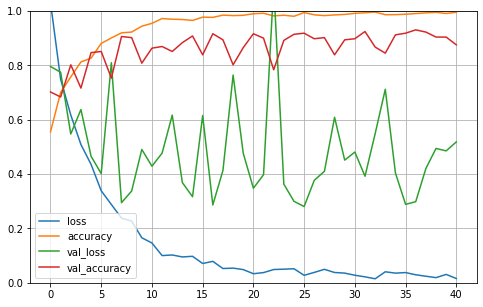

In [20]:
# change directory
os.chdir(r'C:\\Users\diego\OneDrive\Desktop\DS\brain_cancer\Brain_cancer_classification')
print(os.getcwd())

#save the model
model.save(os.path.join('models/','CNN.h5'))
model.save_weights(os.path.join('models/','CNN_weights.h5'))

#plot loss and accuracy
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)

#plt.gca().set_xlim(0,33)
plt.gca().set_ylim(0,1)
plt.savefig(os.path.join('plots/','CNN.png'), dpi=500)
loss, accuracy = model.evaluate(X_test,y_test)

#print accuracy    
print('Accuracy: %f' % (accuracy*100))

## <font color='Lime'>Load the model </font> 

In [7]:
 #load the model
model=keras.models.load_model(os.path.join('models/','CNN.h5'))   
#  More details about the model
#model.summary()
loss, accuracy = model.evaluate(X_test,y_test)


16/16 [==============================] - 13s 16ms/step - loss: 0.2806 - accuracy: 0.9184


In [22]:
# visualize activation functions
for i, layer in enumerate (model.layers):
    print (i, layer)
    try:
        print ("    ",layer.activation)
    except AttributeError:
        print('   no activation attribute')
#specific info about each layer
for i in range(len(model.layers)):
    print(f'{i}   {model.layers[i]}: \n{model.layers[i].get_config()} \n')
#info about optimizers
model.optimizer.get_config()  

0 <keras.layers.convolutional.Conv2D object at 0x00000158109B32B0>
     <function elu at 0x000001573E8C5310>
1 <keras.layers.normalization_v2.BatchNormalization object at 0x00000158109B3F10>
   no activation attribute
2 <keras.layers.pooling.MaxPooling2D object at 0x00000158109E2310>
   no activation attribute
3 <keras.layers.convolutional.Conv2D object at 0x00000158109B3B20>
     <function linear at 0x000001573E8C5F70>
4 <keras.layers.core.Activation object at 0x0000015804F56910>
     <function linear at 0x000001573E8C5F70>
5 <keras.layers.pooling.MaxPooling2D object at 0x00000157F2BABDF0>
   no activation attribute
6 <keras.layers.convolutional.Conv2D object at 0x00000157F2BA3DC0>
     <function elu at 0x000001573E8C5310>
7 <keras.layers.normalization_v2.BatchNormalization object at 0x00000157F2BCE040>
   no activation attribute
8 <keras.layers.pooling.MaxPooling2D object at 0x000001581EB0DB80>
   no activation attribute
9 <keras.layers.convolutional.Conv2D object at 0x000001581EAF7B

{'name': 'Adam',
 'learning_rate': 7e-05,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-08,
 'amsgrad': False}

## <font color='Lime'>Accuracy and Loss</font> 

In [23]:
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

accuracy : 91.837 
 loss : 0.281


In [24]:
#predicted values
pred=np.argmax(model.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred)
pred_labels

array(['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor',
       'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor',
       'glioma_tumor', 'no_tumor', 'meningioma_tumor', 'glioma_tumor',
       'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor',
       'meningioma_tumor', 'glioma_tumor', 'glioma_tumor',
       'pituitary_tumor', 'pituitary_tumor', 'glioma_tumor',
       'meningioma_tumor', 'pituitary_tumor', 'glioma_tumor',
       'pituitary_tumor', 'no_tumor', 'glioma_tumor', 'meningioma_tumor',
       'glioma_tumor', 'pituitary_tumor', 'no_tumor', 'glioma_tumor',
       'glioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'glioma_tumor',
       'no_tumor', 'pituitary_tumor', 'meningioma_tumor',
       'meningioma_tumor', 'pituitary_tumor', 'pituitary_tumor',
       'no_tumor', 'meningioma_tumor', 'pituitary_tumor',
       'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor',
       'pituitary_tumor', 'pituitary_tumor', 'no_tumor',
       'meningioma_tu

## <font color='Lime'>Visualize convolutional layers</font> 

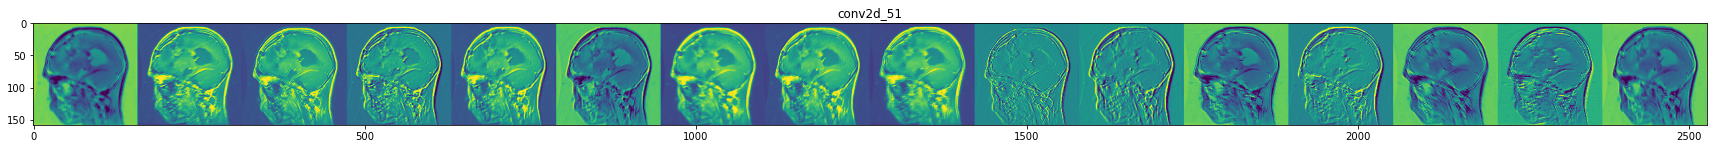

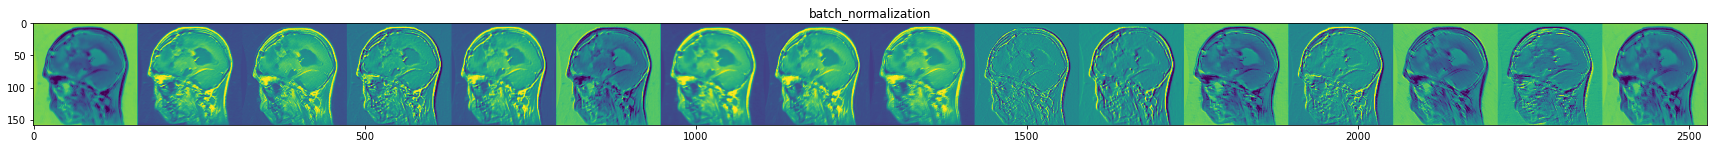

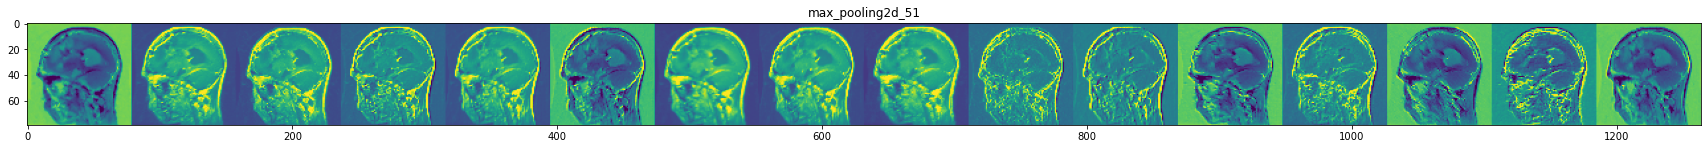

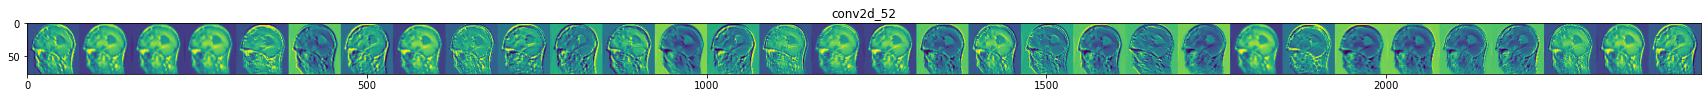

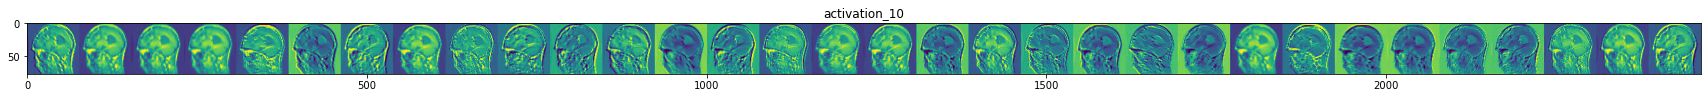

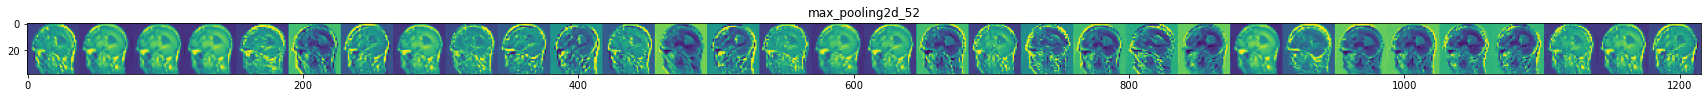

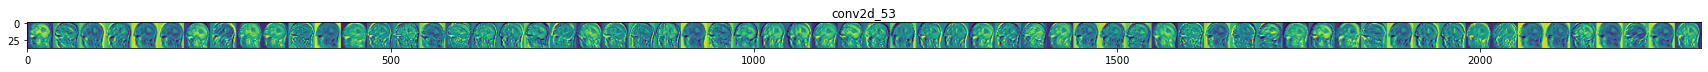

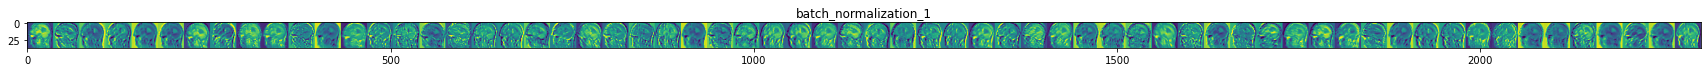

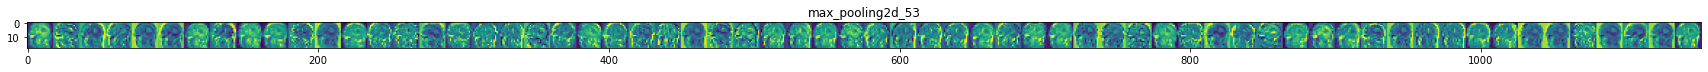

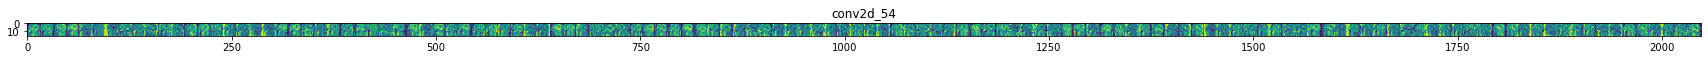

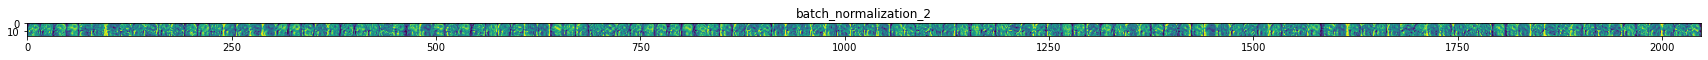

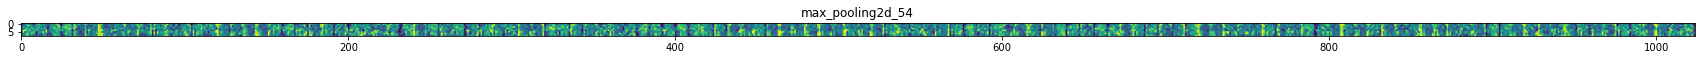

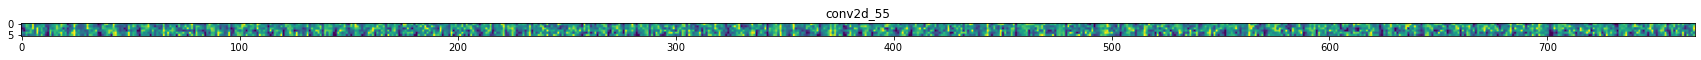

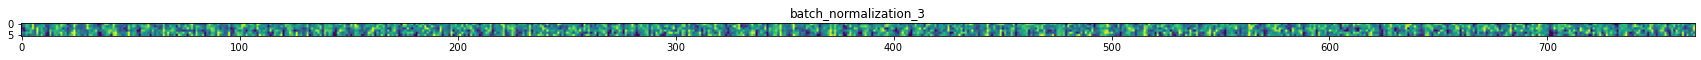

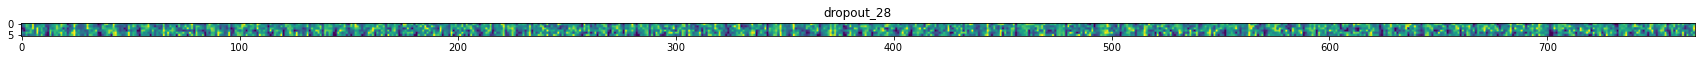

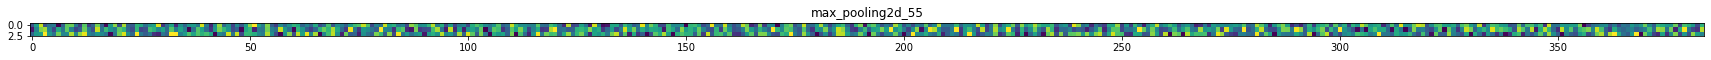

In [45]:
#most of the following code is taken from the second course of 
#"DeepLearning.AI TensorFlow Developer Professional Certificate" of Coursera

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.

x = random.choice(X_test)
#import codecs
#with codecs.open(file_name, 'r', encoding='utf-8',
#                 errors='ignore') as fdata:
#img = load_img(img_path, target_size=(160, 160))  # this is a PIL image

#x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x = x/255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
    if len(feature_map.shape) == 4:

        #-------------------------------------------
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        #-------------------------------------------
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))

        #-------------------------------------------------
        # Postprocess the feature to be visually palatable
        #-------------------------------------------------
        for i in range(n_features):
            x  = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x  = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

        #-----------------
        # Display the grid
        #-----------------

        scale = 30. / n_features
        plt.figure( figsize=(scale * n_features, scale) )
        plt.title ( layer_name )
        plt.grid  ( False )
        plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 
        plt.savefig(os.path.join('plots/conv_layer',f'CNN_layer{layer_name}.png'), dpi=300,facecolor='w')